In [37]:
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.preprocessing import StandardScaler
import numpy as np

from sklearn.decomposition import PCA
from scipy import linalg

import seaborn as sns

from sklearn.cluster import KMeans
from adspy_shared_utilities import plot_labelled_scatter



#https://aws.amazon.com/blogs/machine-learning/analyze-us-census-data-for-population-segmentation-using-amazon-sagemaker/
#https://github.com/aws/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/US-census_population_segmentation_PCA_Kmeans/sagemaker-countycensusclustering.ipynb

In [2]:
census_df = pd.read_excel(r"Amazons3CensusData.xlsx")
pd.options.display.max_columns = 37

## Categories of columns

- Race
- Income
- Job type
- Level of income
- Employed/Self/unemployment

In [3]:
census_df["STATE_COUNTY"] = census_df["STATE"] + "_" +  census_df["COUNTY"]
census_df.drop(columns = ["STATE", "COUNTY", 'CENSUSID'], inplace=True)
census_df = census_df[['STATE_COUNTY','TOTALPOP', 'MEN', 'WOMEN', 'HISPANIC',
                       'WHITE', 'BLACK', 'NATIVE', 'ASIAN', 'PACIFIC', 'CITIZEN', 'INCOME',
                       'INCOMEERR', 'NCOMEPERCAP', 'INCOMEPERCAPERR', 'POVERTY',
                       'CHILDPOVERTY', 'PROFESSIONAL', 'SERVICE', 'OFFICE', 'CONSTRUCTION',
                       'PRODUCTION', 'DRIVE', 'CARPOOL', 'TRANSIT', 'WALK', 'OTHERTRANSP',
                       'WORKATHOME', 'MEANCOMMUTE', 'EMPLOYED', 'PRIVATEWORK', 'PUBLICWORK',
                       'SELFEMPLOYED', 'FAMILYWORK', 'UNEMPLOYMENT']]

census_df.head()



numeric_features = ['TOTALPOP', 'MEN', 'WOMEN', 'HISPANIC', 'WHITE',
                   'BLACK', 'NATIVE', 'ASIAN', 'PACIFIC', 'CITIZEN', 'INCOME', 'INCOMEERR',
                   'NCOMEPERCAP', 'INCOMEPERCAPERR', 'POVERTY', 'CHILDPOVERTY',
                   'PROFESSIONAL', 'SERVICE', 'OFFICE', 'CONSTRUCTION', 'PRODUCTION',
                   'DRIVE', 'CARPOOL', 'TRANSIT', 'WALK', 'OTHERTRANSP', 'WORKATHOME',
                   'MEANCOMMUTE', 'EMPLOYED', 'PRIVATEWORK', 'PUBLICWORK', 'SELFEMPLOYED',
                   'FAMILYWORK', 'UNEMPLOYMENT']



pd.options.display.max_rows = 4000
census_df.dropna(inplace=True)
census_df = census_df[census_df['STATE_COUNTY']!='State_County'].copy()

for col in numeric_features:
    census_df[col] = census_df[col].astype('float')
    
census_df.set_index('STATE_COUNTY',inplace=True)

In [4]:
def plotDistributionForColumn(df, colName):

    """
        This function plots a histogram for a column of the df  dataframe 
        At the botton of the histogram, it plots a boxplot
    """
    source = df[[colName]]

    base = alt.Chart(source, title=colName)

    B = base.mark_bar(color='green').encode(
        alt.X(f"{colName}:Q", bin=alt.Bin(maxbins=100)),
        y='count()',
    )


    mean_rule = alt.Chart(source).mark_rule(color='red').encode(
        x=f'mean({colName}):Q'
    )

    median_rule = alt.Chart(source).mark_rule(color='orange').encode(
        x=f'median({colName}):Q'
    )

    box_plot = base.mark_boxplot().encode(
        x=f'{colName}:Q',

    )

    return B + mean_rule + median_rule & box_plot
    


In [5]:

# Call the function in a cell using IPython display to chart all the columns at the same time
from IPython.display import display

for col in numeric_features:
    chart = plotDistributionForColumn(census_df, col)
    display(chart)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

In [6]:
#The Men and Wonen graphs have noticeable outliers that suspciciously look like bad data but this belongs to California
census_df[census_df['MEN'] > 4000000]

,TOTALPOP,MEN,WOMEN,HISPANIC,WHITE,BLACK,NATIVE,ASIAN,PACIFIC,CITIZEN,INCOME,INCOMEERR,NCOMEPERCAP,INCOMEPERCAPERR,POVERTY,CHILDPOVERTY,PROFESSIONAL,SERVICE,OFFICE,CONSTRUCTION,PRODUCTION,DRIVE,CARPOOL,TRANSIT,WALK,OTHERTRANSP,WORKATHOME,MEANCOMMUTE,EMPLOYED,PRIVATEWORK,PUBLICWORK,SELFEMPLOYED,FAMILYWORK,UNEMPLOYMENT
STATE_COUNTY,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
California_Los Angeles,10038388.0,4945351.0,5093037.0,48.2,26.9,8.0,0.2,14.0,0.2,6046749.0,56196.0,270.0,28337.0,113.0,18.2,25.8,35.7,19.1,24.6,7.8,12.8,73.0,9.9,6.8,2.8,2.3,5.1,30.0,4635465.0,79.0,11.5,9.4,0.2,10.0


In [7]:
#andardize features by removing the mean and scaling to unit varianc
from sklearn.preprocessing import StandardScaler
import numpy as np



scaler = StandardScaler()
census_scaled_df = pd.DataFrame(scaler.fit_transform(census_df))
census_scaled_df.columns = census_df.columns
census_scaled_df.index = census_df.index


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=5))])
pipeline_pca = pipeline.fit_transform(census_df)

In [8]:
# from sklearn.preprocessing import StandardScaler
# X = df[feature_names[1:6]].to_numpy()
# X_beer_normalized = StandardScaler().fit(X).transform(X)  

In [9]:
census_scaled_df.head()

,TOTALPOP,MEN,WOMEN,HISPANIC,WHITE,BLACK,NATIVE,ASIAN,PACIFIC,CITIZEN,INCOME,INCOMEERR,NCOMEPERCAP,INCOMEPERCAPERR,POVERTY,CHILDPOVERTY,PROFESSIONAL,SERVICE,OFFICE,CONSTRUCTION,PRODUCTION,DRIVE,CARPOOL,TRANSIT,WALK,OTHERTRANSP,WORKATHOME,MEANCOMMUTE,EMPLOYED,PRIVATEWORK,PUBLICWORK,SELFEMPLOYED,FAMILYWORK,UNEMPLOYMENT
STATE_COUNTY,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Alabama_Lee,0.161302,0.161771,0.160812,-0.379743,-0.316390,1.003460,-0.223484,0.795767,-0.182552,0.207667,-0.120375,-0.363570,0.061674,-0.564919,0.758668,-0.016108,1.367360,-0.617287,0.215079,-1.048968,-0.476189,0.709184,-0.783837,0.009010,-0.300249,-0.368150,-0.481834,-0.282801,0.153569,0.161762,0.426916,-0.979356,-0.413675,-0.194209
Alabama_Tuscaloosa,0.316231,0.305383,0.326607,-0.405731,-0.521462,1.535684,-0.223484,0.106047,-0.182552,0.410403,0.034199,-0.818946,-0.137286,-0.782527,0.193536,0.112200,0.644958,-0.039485,-0.160480,-0.859068,0.029316,0.866794,-0.439944,-0.187107,-0.516540,-0.428591,-0.670947,-0.211318,0.281015,0.353671,0.210101,-1.004907,-0.413675,-0.120902
Arkansas_Drew,-0.252802,-0.253427,-0.252140,-0.421324,-0.373112,1.409631,-0.223484,-0.353767,-0.182552,-0.271101,-1.030852,-0.192805,-1.048595,-0.126816,1.335823,1.172885,0.786298,-0.644801,0.027299,-0.503007,-0.110134,0.262625,1.245132,-0.317852,-0.408394,-0.489032,-0.733985,-0.211318,-0.255552,-0.554701,0.767625,-0.110599,-0.413675,1.516278
Connecticut_Fairfield,2.631983,2.608197,2.654284,0.379116,-0.495283,0.121089,-0.223484,1.447169,-0.182552,2.656744,2.952745,-0.833568,4.225142,-0.766158,-1.020896,-1.111009,2.058353,-0.204571,0.496749,-1.238867,-1.522061,-0.893176,-0.680669,2.918078,-0.192103,-0.247267,0.306139,1.093253,2.791828,0.942194,-1.199195,0.119365,-0.413675,0.221195
Connecticut_Middlesex,0.205714,0.203743,0.207565,-0.280987,0.412273,-0.278079,-0.223484,0.604178,-0.182552,0.279558,2.616479,-0.417881,2.794308,-0.355015,-1.297450,-1.453166,2.309623,-0.809887,0.215079,-1.167655,-1.312887,0.446502,-1.162119,0.237813,-0.110994,-0.307708,0.022469,0.432032,0.282191,0.711902,-0.688132,-0.238358,-0.413675,-0.511870


# Apply PCA On All Fearures to find optimal number of reduced components

In [10]:
from sklearn.decomposition import PCA
from scipy import linalg

pca = PCA(n_components = census_scaled_df.shape[1], random_state=0).fit(census_scaled_df)


In [11]:
print(pca.n_components)
print(pca.components_.shape)

34
(34, 34)


In [12]:
def biplot(score, coeff, maxdim, pcax, pcay, labels=None):
    """
      This function uses 
      score - the transformed data returned by pca - data as expressed according to the new axis
      coeff - the loadings from the pca_components_
      
      For the feaures we are interested in, it plots the correlation between the original features and the PCAs.
      Use cosine similarity and angle measures between axes.
      
      It shows how the data is related to the ORIGINAL features in the positive and negative direction.
      
    """
    zoom = 0.5
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n = min(coeff.shape[0], maxdim)
    width = 2.0 * zoom
    scalex = width/(xs.max()- xs.min())
    scaley = width/(ys.max()- ys.min())
    text_scale_factor = 1.3
        
    fig = plt.gcf()
    fig.set_size_inches(9, 9)
    
    plt.scatter(xs*scalex, ys*scaley, s=9)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],
                  color='b',alpha=0.9, head_width = 0.03 * zoom) 
        if labels is None:
            plt.text(coeff[i,pca1]* text_scale_factor, 
                     coeff[i,pca2] * text_scale_factor, 
                     "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i,pca1]* text_scale_factor, 
                     coeff[i,pca2] * text_scale_factor, 
                     labels[i], color='g', ha='center', va='center')
    
    plt.xlim(-zoom,zoom)
    plt.ylim(-zoom,zoom)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()
    return 

plt.figure()

# feature_subset = slice(0, feature_subset_count, 1)

# biplot(X_pca, np.transpose(pca.components_[0:2, feature_subset]), 
#        feature_subset_count, 1, 2, labels=feature_names[feature_subset])

# print("explained_variance_ratio:", pca.explained_variance_ratio_)
# print("sum of explained variance ratios:", np.sum(pca.explained_variance_ratio_))
# print("singular values:", pca.singular_values_)  

# # The variances of the PCs are given by the squares of the singular values of X*, divided by n−1. 
# # Since they are the eigenvalues of the (n-1)S matrix where S is the correlation matrix of X
# print(np.power(pca.singular_values_, 2) / (scaled_features.shape[0] - 1))
# print(scaled_features.shape[0])

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

# Pick relevant pca 

Text(0.5, 1.0, "Variance Explained by PCA's")

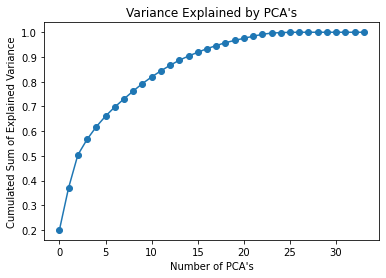

In [13]:
# Standardize the data
import matplotlib.pyplot as plt


# Find the optimal number of PCA 
pca = PCA(n_components=census_scaled_df.shape[1])
pca.fit(census_scaled_df)
ratios = pca.explained_variance_ratio_

# Plot the explained variance ratios
x = np.arange(census_scaled_df.shape[1])
plt.plot(x, np.cumsum(ratios), '-o')
plt.xlabel("Number of PCA's")
plt.ylabel("Cumulated Sum of Explained Variance")
plt.title("Variance Explained by PCA's")



In [14]:
# Find the optimal number of PCA's
for i in range(np.cumsum(ratios).shape[0]):
  if np.cumsum(ratios)[i] >= 0.70:
    num_pca = i + 1
    print ("The optimal number of PCA's is: {}".format(num_pca))
    break
  else:
    continue

The optimal number of PCA's is: 8


# Now that optimal number of PCAs is known, use that to create Biplots

In [15]:
feature_subset_count = 8
feature_subset = slice(0, feature_subset_count, 1)

# biplot(X_pca, np.transpose(pca.components_[0:2, feature_subset]), 
#        feature_subset_count, 1, 2, labels=feature_names[feature_subset])


# Percentage of variation : variation explained by 8 components over all variation

In [16]:
pd.options.display.float_format = "{:,.2f}".format

In [17]:

pca = PCA(n_components = census_scaled_df.shape[1], random_state=0).fit(census_scaled_df)
from scipy import linalg
print(pca.explained_variance_)
U, s, Vh = linalg.svd(census_scaled_df)
s_df = pd.DataFrame(s)
v_df = pd.DataFrame(Vh)

[6.82245806e+00 5.81902517e+00 4.50161886e+00 2.13628025e+00
 1.73753307e+00 1.45784267e+00 1.25132619e+00 1.11065286e+00
 1.08674422e+00 1.02866048e+00 9.10693846e-01 8.40057177e-01
 7.58994606e-01 7.02528763e-01 5.73067526e-01 5.20445104e-01
 4.96411942e-01 4.19515041e-01 4.04795641e-01 3.07436129e-01
 2.90329464e-01 2.86822257e-01 2.57650869e-01 1.77431937e-01
 5.82908855e-02 4.46610803e-02 4.48961398e-03 2.69669871e-03
 1.70786488e-03 2.92240719e-04 4.63157955e-05 3.51581297e-05
 2.68624922e-05 8.23211536e-32]


# This is the explained ratio for the top 8 components

In [18]:
s_df.iloc[0:8, :].apply(lambda x: x * x).sum() / s_df.apply(lambda x: x * x).sum()

0   0.73
dtype: float64

In [19]:
s_df.iloc[0:8, :]

,0
0,148.15
1,136.82
2,120.34
3,82.90
4,74.76
5,68.48
6,63.45
7,59.77


In [20]:
s_8_df = s_df.iloc[0:8, :]
v_8_df = v_df.iloc[:, 0:8]
v_8_df.columns = [0, 1, 2, 3, 4, 5, 6, 7]

In [21]:
#https://towardsdatascience.com/pca-and-svd-explained-with-numpy-5d13b0d2a4d8
def svd(X):
  # Data matrix X, X doesn't need to be 0-centered
  n, m = X.shape
  # Compute full SVD
  U, Sigma, Vh = np.linalg.svd(X, 
      full_matrices=False, # It's not necessary to compute the full matrix of U or V
      compute_uv=True)
  # Transform X with SVD components
  X_svd = np.dot(U, np.diag(Sigma))
  return X_svd

In [22]:
svd(census_scaled_df)

array([[-1.14642232e+00, -9.30629284e-01, -4.04793048e-01, ...,
         6.49230634e-05,  5.87310148e-04, -1.51337517e-14],
       [-1.07852089e+00, -1.56876263e+00, -8.44973183e-01, ...,
        -7.91407908e-05, -1.14605879e-05,  1.52037956e-16],
       [ 1.46688605e+00, -2.16200679e+00,  4.05571909e-01, ...,
        -6.55604877e-04,  2.79871083e-05,  2.32396698e-17],
       ...,
       [-1.81890456e+00,  5.90544718e-01,  8.71075122e-01, ...,
        -2.37664623e-06,  9.71376821e-05,  1.41242419e-18],
       [ 5.28177729e-01,  1.17142855e+00, -1.23296744e+00, ...,
        -6.53270332e-04,  9.41575959e-03,  2.58632544e-17],
       [-1.68514380e-01,  1.18156502e+00, -1.02925291e+00, ...,
        -6.97404167e-04,  9.95509185e-04, -3.15280386e-17]])

In [23]:
def plot_components(pca_num):
    component_num = pca_num

    first_comp = v_8_df[component_num]
    comps = pd.DataFrame(
        list(zip(first_comp, census_scaled_df.columns)), columns=["weights", "features"]
    )
    comps["abs_weights"] = comps["weights"].apply(lambda x: np.abs(x))
    ax = sns.barplot(
        data=comps.sort_values("abs_weights", ascending=False).head(10),
        x="weights",
        y="features",
        palette="Blues_d",
    )
    ax.set_title("PCA Component Makeup: #" + str(component_num))
    plt.show()

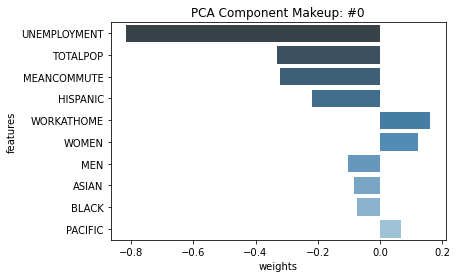

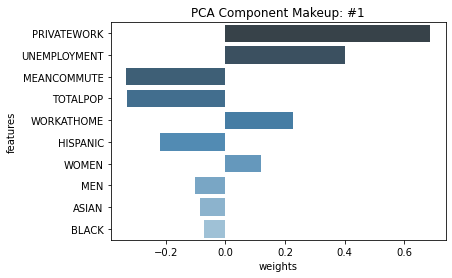

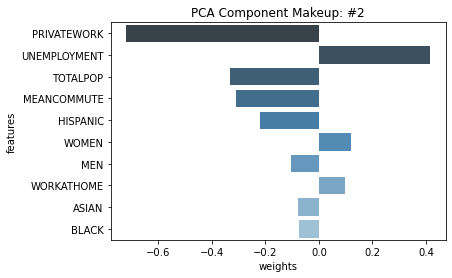

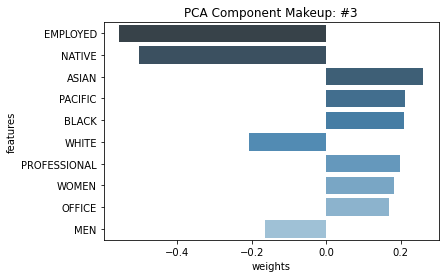

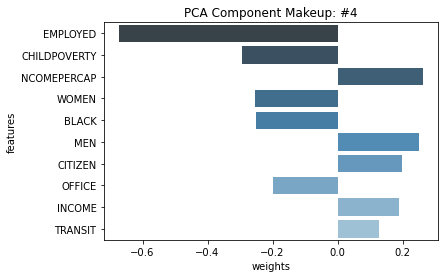

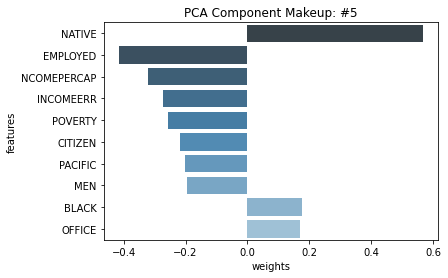

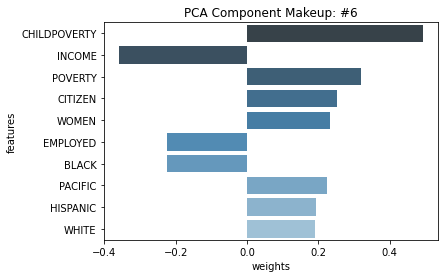

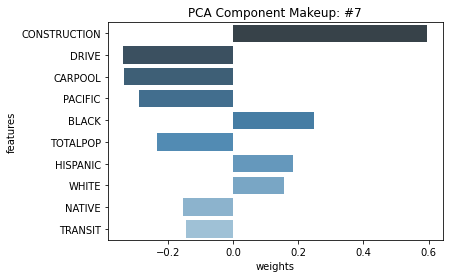

KeyError: 8

In [81]:
for pca_num in range (9):
    plot_components(pca_num)

# Using above we get the component names as best as we can

- PCA_list=["Poverty/Unemployment", "Self Employment/Public Workers", "High Income/Professional & Office Workers", \
-          "Black/Native Am Populations & Public/Professional Workers", "Construction & Commuters"]

-  comp_1 = ['UNEMPLOYMENT/TOTALPOP']
-  comp_2 = ['PRIVATEWORK/UNEMPLOYMENT']
-  comp_3 = ['PRIVATEWORK/UNEMPLOYMENT']
-  comp_4 = ['EMPLOYED/NATIVE']
-  comp_5 = ['EMPLOYED/CHILDPOVERTY']
-  comp_6 = ['NATIVE/EMPLOYED']
-  comp_7 = ['POVERTY/INCOME']
-  comp_8 = ['CONSTRUCTION/COMMUTE (DRIVE/CARPOOL)']




# Scree plot to explain optimal number of components

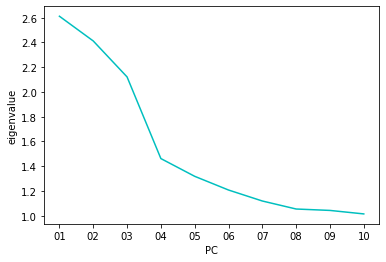

In [25]:
df = pd.DataFrame({'eigenvalue': np.sqrt(pca.explained_variance_[:10]),
                   'PC':['01','02','03','04','05','06','07','08','09','10']})
sns.lineplot(x = 'PC',y = "eigenvalue", data = df, color="c");

#  Variance plot to pick components

0   0.20
1   0.37
2   0.50
3   0.57
4   0.62
5   0.66
6   0.70
7   0.73
8   0.76
9   0.79
Name: explained var ratio, dtype: float64

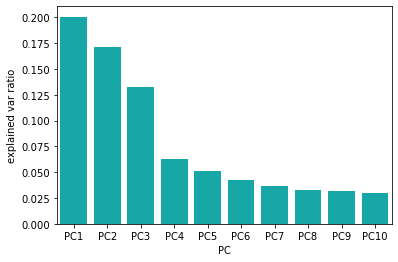

In [26]:
df = pd.DataFrame({'explained var ratio':pca.explained_variance_ratio_[:10],
                   'PC':['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']})
sns.barplot(x = 'PC',y = "explained var ratio", data = df, color="c");
np.cumsum(df['explained var ratio'])

### Both the Scree Plot and the variance plot suggest three components describe highest variance
- PRIVATEWORK/UNEMPLOYMENT']
- comp_2 = ['PRIVATEWORK/UNEMPLOYMENT']
- comp_3 = ['EMPLOYED/NATIVE

# Now that we have selected numeber of relavant components, create a model by transforming original data

In [27]:
# Example using the 'pca' library in order to use their built-in biplot routine.
# Currently not supported in the Coursera environment. If you don't have this library locally, you can run: pip install pca

from pca import pca as pypca
#feature_names = census_scaled_df.columns
#feature_subset = 

pca_model= pypca(n_components = 8)
results = pca_model.fit_transform(census_scaled_df)



[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [34] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[8]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


# Future work Try PCA on

In [28]:
#https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey

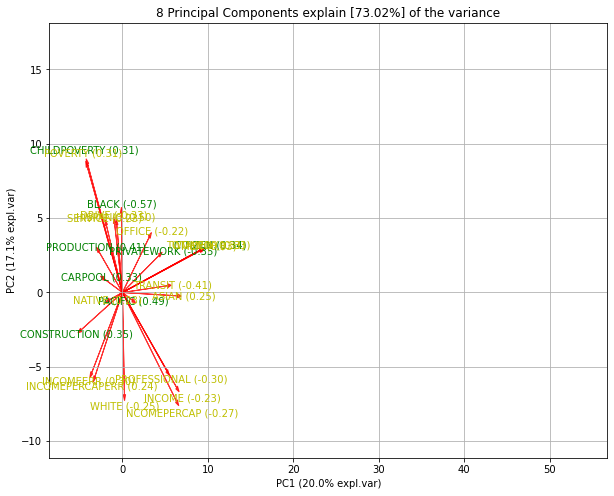

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1cf57f34b88>)

In [29]:
#https://pypi.org/project/pca/

# Make plot with parameters: set cmap to None and label and legend to False. Only directions will be plotted.
pca_model.biplot(cmap=None, label=False, legend=False)

In [30]:
results.keys()

dict_keys(['loadings', 'PC', 'explained_var', 'model', 'scaler', 'pcp', 'topfeat', 'outliers', 'outliers_params'])

# Now that we have plotted our components, get back to creating the model

In [31]:
pca_chosencomp_model = PCA(n_components = 8, random_state=0).fit(census_scaled_df)
result_chosen_comp =      pca_chosencomp_model.transform(census_scaled_df)

In [32]:
result_chosen_comp

array([[ 1.14642234,  0.93062935, -0.40479353, ..., -0.29492909,
        -0.80239731,  0.46138968],
       [ 1.0785209 ,  1.56876271, -0.84497319, ..., -0.316671  ,
        -1.05310658,  0.74688921],
       [-1.46688602,  2.16200676,  0.40557226, ...,  0.08545306,
        -1.22846705,  0.25671556],
       ...,
       [ 1.8189046 , -0.59054484,  0.87107511, ..., -0.4670316 ,
         0.75224738,  0.02512658],
       [-0.52817775, -1.17142838, -1.2329671 , ..., -0.88169776,
         0.47390431,  0.46496713],
       [ 0.16851445, -1.18156506, -1.02925231, ...,  2.73859819,
         0.96292721,  0.49607979]])

In [33]:
result_chosen_comp.shape
#
(3218, 8)

(3218, 8)

# Now with the top components we move to the task of clustering

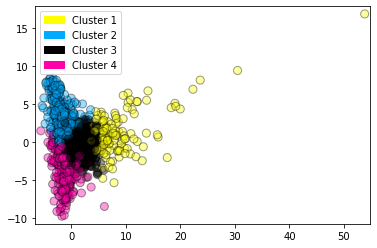

In [60]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 4, random_state = 0)
kmeans.fit(result_chosen_comp)

plot_labelled_scatter(result_chosen_comp, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])

num_clusters = 7


In [54]:
result_kmeans_transform = kmeans.transform(result_chosen_comp)
result_kmeans_transform

array([[5.4675397 , 2.45888801, 6.88524148],
       [5.96763085, 2.300058  , 7.09132275],
       [5.5443216 , 2.55924162, 9.24959902],
       ...,
       [4.36918687, 3.33709955, 6.11237168],
       [4.39733806, 2.98932427, 9.09429582],
       [5.07325128, 3.91711225, 8.47988459]])

In [55]:
result_kmeans_predict = kmeans.predict(result_chosen_comp)

In [56]:
result_kmeans_predict

array([1, 1, 1, ..., 1, 1, 1])

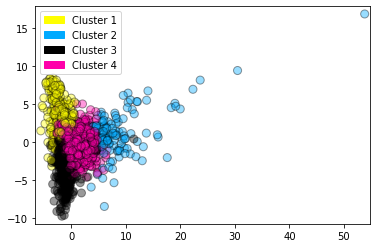

In [61]:
from sklearn.cluster import AgglomerativeClustering
from adspy_shared_utilities import plot_labelled_scatter


cls = AgglomerativeClustering(n_clusters = 4)
cls_assignment = cls.fit_predict(result_chosen_comp)

plot_labelled_scatter(result_chosen_comp, cls_assignment, 
        ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])

# Find Optimal Clusters

In [ ]:
## Find optimal value of K -- THIS TURNS OUT TO BE 2
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import calinski_harabasz_score
# from sklearn.metrics import davies_bouldin_score

# davies_bouldin_score_list = []
# calinski_harabasz_score_list = []


# for cluster_sel in range(2,10):
#     kmeans = KMeans(n_clusters = cluster_sel,
#                     init='k-means++',
#                     max_iter=100,
#                     n_init=1,
#                     random_state=42)
#     kmeans.fit(X)
#     davies_bouldin_score_list += [davies_bouldin_score(X.toarray(), kmeans.labels_)]
#     calinski_harabasz_score_list += [calinski_harabasz_score(X.toarray(), kmeans.labels_)]


In [62]:
from sklearn.cluster import KMeans

#USe the optimal K of 2 and find centroids
kmeans = KMeans(n_clusters = 4,
                    init='k-means++',
                    max_iter=100,
                    n_init=1,
                    random_state=42)
kmeans.fit(result_chosen_comp)

# def answer_kmeans_review():
#    #Since there are 1000 terms or features in each cluster, the centroid in each cluster has a length of 1000
#     cluster_center_1 = kmeans.cluster_centers_[0]
#     cluster_center_2 = kmeans.cluster_centers_[1]
#     cluster_center_1_ind = cluster_center_1.argsort()[::-1][:10]
#     cluster_center_2_ind = cluster_center_2.argsort()[::-1][:10]
#     centroids = np.vstack((cluster_center_1_ind, cluster_center_2_ind))
#     terms = vectorizer.get_feature_names()
    
#     first_cluster_terms = [terms[ind] for ind in cluster_center_1_ind]
#     second_cluster_terms = [terms[ind] for ind in cluster_center_2_ind]
   
#     return [first_cluster_terms, second_cluster_terms]

KMeans(max_iter=100, n_clusters=4, n_init=1, random_state=42)

# For every cluster, which of the PCA's influence it most

In [67]:
l_cluster_centers = [kmeans.cluster_centers_[i] for i in range (len(kmeans.cluster_centers_))]

In [74]:
num_pca_comp = 8
l_cluster_centers_ind = [l_cluster_centers[i].argsort()[::-1][:num_pca_comp] for i in range (len(kmeans.cluster_centers_))]

[print(l_cluster_centers_ind[i]) for i in range (len(kmeans.cluster_centers_))]

[1 2 5 3 7 4 6 0]
[0 6 4 7 5 3 1 2]
[2 3 7 6 5 4 0 1]
[0 2 1 5 3 4 6 7]


[None, None, None, None]

In [75]:
l_cluster_centers

[array([-1.64290526,  2.53725997,  0.85661296,  0.07725316, -0.18779785,
         0.4181069 , -0.31711623,  0.04517497]),
 array([ 0.34790169, -0.24926983, -1.09374893, -0.20407133,  0.10876575,
        -0.19027127,  0.15305739, -0.01631195]),
 array([-1.14806503, -3.3670364 ,  2.43138994,  0.62530765, -0.18198639,
        -0.11338657, -0.09544686,  0.01702187]),
 array([ 9.079147  ,  1.29514104,  2.29456523,  0.27245371,  0.16855637,
         0.81786226, -0.05768724, -0.08966816])]

In [79]:
l_cluster_centers_matrix = np.vstack(l_cluster_centers)

In [82]:
# PCA_list=["Poverty/Unemployment", "Self Employment/Public Workers", "High Income/Professional & Office Workers", \
# "Black/Native Am Populations & Public/Professional Workers", "Construction & Commuters"]

comp_1 = 'UNEMPLOYMENT/TOTALPOP'
comp_2 = 'PRIVATEWORK/UNEMPLOYMENT'
comp_3 = 'PRIVATEWORK/UNEMPLOYMENT'
comp_4 = 'EMPLOYED/NATIVE'
comp_5 = 'EMPLOYED/CHILDPOVERTY'
comp_6 = 'NATIVE/EMPLOYED'
comp_7 = 'POVERTY/INCOME'
comp_8 = 'CONSTRUCTION/COMMUTE (DRIVE/CARPOOL)'




PCA_list= [comp_1, comp_2, comp_3, comp_4, comp_5, comp_6, comp_7, comp_8]


In [84]:
l_cluster_centers_df = pd. DataFrame(l_cluster_centers_matrix, columns=PCA_list)

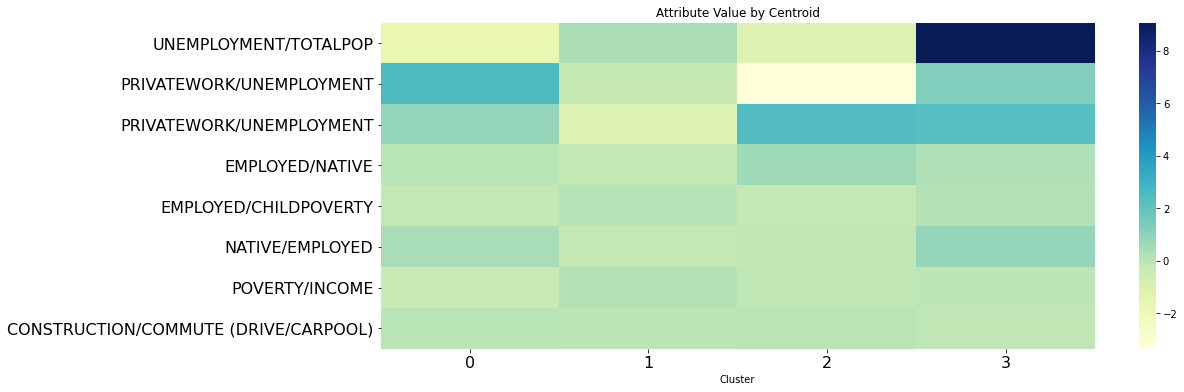

In [86]:
plt.figure(figsize=(16, 6))
ax = sns.heatmap(l_cluster_centers_df.T, cmap="YlGnBu")
ax.set_xlabel("Cluster")
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax.set_title("Attribute Value by Centroid")
plt.show()